In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from fbprophet import Prophet

In [3]:
from fbprophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [4]:
sales_df = pd.read_csv('train.csv') #read training file

In [5]:
sales_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2/5/2010,24924.50,False
1,1,1,2/12/2010,46039.49,True
2,1,1,2/19/2010,41595.55,False
3,1,1,2/26/2010,19403.54,False
4,1,1,3/5/2010,21827.90,False


In [6]:
sales_df.tail() #sales_df contains many stores and depts in the dataset

,Store,Dept,Date,Weekly_Sales,IsHoliday
421565,45,98,9/28/2012,508.37,False
421566,45,98,10/5/2012,628.10,False
421567,45,98,10/12/2012,1061.02,False
421568,45,98,10/19/2012,760.01,False
421569,45,98,10/26/2012,1076.80,False


In [7]:
# Get timeseries for one store & dept. Only getting date and weekly_Sales info here as fbprophet only 
## needs date and value to forecast. Holiday data will be used as separate dataframe

df = sales_df[(sales_df['Store']==1)&(sales_df['Dept']==1)][['Date', 'Weekly_Sales']] 

In [8]:
df.head()

,Date,Weekly_Sales
0,2/5/2010,24924.50
1,2/12/2010,46039.49
2,2/19/2010,41595.55
3,2/26/2010,19403.54
4,3/5/2010,21827.90


In [9]:
df.tail()

,Date,Weekly_Sales
138,9/28/2012,18947.81
139,10/5/2012,21904.47
140,10/12/2012,22764.01
141,10/19/2012,24185.27
142,10/26/2012,27390.81


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 0 to 142
Data columns (total 2 columns):
Date            143 non-null object
Weekly_Sales    143 non-null float64
dtypes: float64(1), object(1)
memory usage: 3.4+ KB


In [11]:
df['Date'] = pd.DatetimeIndex(df['Date']) #convert date to date datatype

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 0 to 142
Data columns (total 2 columns):
Date            143 non-null datetime64[ns]
Weekly_Sales    143 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.4 KB


In [13]:
df = df.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'}) #rename the cols as needed by fbprophet

In [14]:
df.head()

,ds,y
0,2010-02-05,24924.50
1,2010-02-12,46039.49
2,2010-02-19,41595.55
3,2010-02-26,19403.54
4,2010-03-05,21827.90


In [15]:
orig_df = df.copy()

In [16]:
#orig_df

In [17]:
df.head()

,ds,y
0,2010-02-05,24924.50
1,2010-02-12,46039.49
2,2010-02-19,41595.55
3,2010-02-26,19403.54
4,2010-03-05,21827.90


In [18]:
# Visualize the data

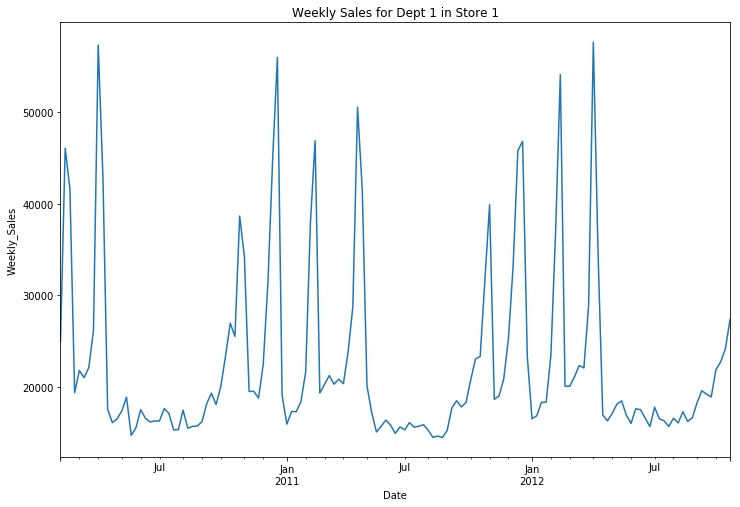

In [19]:
df.set_index('ds').y.plot(figsize=(12,8))
plt.xlabel('Date')
plt.ylabel('Weekly_Sales')
plt.title('Weekly Sales for Dept 1 in Store 1');

In [20]:
## Get the holiday info for Store 1, Dept 1
sales_df[(sales_df['Store']==1) & (sales_df['Dept']==1)&(sales_df['IsHoliday']==True)][['Date']]

,Date
1,2/12/2010
31,9/10/2010
42,11/26/2010
47,12/31/2010
53,2/11/2011
83,9/9/2011
94,11/25/2011
99,12/30/2011
105,2/10/2012
135,9/7/2012


In [21]:
holiday_dates = sales_df[(sales_df['Store']==1) & (sales_df['Dept']==1)&(sales_df['IsHoliday']==True)][['Date']]

In [22]:
holiday_dates

,Date
1,2/12/2010
31,9/10/2010
42,11/26/2010
47,12/31/2010
53,2/11/2011
83,9/9/2011
94,11/25/2011
99,12/30/2011
105,2/10/2012
135,9/7/2012


In [23]:
holiday_dates['Date'].values

array(['2/12/2010', '9/10/2010', '11/26/2010', '12/31/2010', '2/11/2011',
       '9/9/2011', '11/25/2011', '12/30/2011', '2/10/2012', '9/7/2012'], dtype=object)

In [24]:
## Create holiday df with lower and upper window = 0, as we do not want to extend the holiday out
# to days around the given date

holidays_df = pd.DataFrame({
    'holiday': 'national_holiday',
    'ds': pd.to_datetime(holiday_dates['Date'].values),
    'lower_window': 0,
    'upper_window': 0
})

In [25]:
holidays_df

,ds,holiday,lower_window,upper_window
0,2010-02-12,national_holiday,0,0
1,2010-09-10,national_holiday,0,0
2,2010-11-26,national_holiday,0,0
3,2010-12-31,national_holiday,0,0
4,2011-02-11,national_holiday,0,0
5,2011-09-09,national_holiday,0,0
6,2011-11-25,national_holiday,0,0
7,2011-12-30,national_holiday,0,0
8,2012-02-10,national_holiday,0,0
9,2012-09-07,national_holiday,0,0


In [26]:
## Split train and test set 

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 0 to 142
Data columns (total 2 columns):
ds    143 non-null datetime64[ns]
y     143 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.4 KB


In [35]:
train_df = df[:100] #split train, test into 70/30 of df
test_df = df[100:]

In [36]:
train_df.head()

,ds,y
0,2010-02-05,24924.50
1,2010-02-12,46039.49
2,2010-02-19,41595.55
3,2010-02-26,19403.54
4,2010-03-05,21827.90


In [37]:
train_df.tail()

,ds,y
95,2011-12-02,25293.49
96,2011-12-09,33305.92
97,2011-12-16,45773.03
98,2011-12-23,46788.75
99,2011-12-30,23350.88


In [38]:
test_df.head()

,ds,y
100,2012-01-06,16567.69
101,2012-01-13,16894.40
102,2012-01-20,18365.10
103,2012-01-27,18378.16
104,2012-02-03,23510.49


In [39]:
test_df.tail()

,ds,y
138,2012-09-28,18947.81
139,2012-10-05,21904.47
140,2012-10-12,22764.01
141,2012-10-19,24185.27
142,2012-10-26,27390.81


In [40]:
## Using Prophet

In [41]:
model = Prophet(holidays=holidays_df, weekly_seasonality=True) # include holiday effects in the forecast when instantiating Prophet

In [42]:
# Fit model on train data
model.fit(train_df)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [43]:
# Define future timeframe, with 43 weeks, since this is the number of weeks we have in the test_df
future = model.make_future_dataframe(periods=43, freq='W-FRI') 

In [44]:
future.head()

,ds
0,2010-02-05
1,2010-02-12
2,2010-02-19
3,2010-02-26
4,2010-03-05


In [45]:
future.tail()

,ds
138,2012-09-28
139,2012-10-05
140,2012-10-12
141,2012-10-19
142,2012-10-26


In [46]:
# Use predict method to forecast for the future timeframe
forecast = model.predict(future)

In [47]:
forecast.tail()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,holidays,holidays_lower,holidays_upper,national_holiday,...,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yhat
138,2012-09-28,22181.035217,22180.777328,22181.303174,9115.857354,34851.386291,0.0,0.0,0.0,0.0,...,-845.72159,-845.72159,-845.72159,-845.72159,-845.72159,-845.72159,-845.72159,-845.72159,-845.72159,21335.313627
139,2012-10-05,22163.338160,22163.069623,22163.618800,7611.571288,33430.375838,0.0,0.0,0.0,0.0,...,-845.72159,-845.72159,-845.72159,-845.72159,-845.72159,-845.72159,-845.72159,-845.72159,-845.72159,21317.616571
140,2012-10-12,22145.641104,22145.361575,22145.931965,8378.269503,34633.255215,0.0,0.0,0.0,0.0,...,-845.72159,-845.72159,-845.72159,-845.72159,-845.72159,-845.72159,-845.72159,-845.72159,-845.72159,21299.919514
141,2012-10-19,22127.944047,22127.654412,22128.243413,7753.069411,34326.312220,0.0,0.0,0.0,0.0,...,-845.72159,-845.72159,-845.72159,-845.72159,-845.72159,-845.72159,-845.72159,-845.72159,-845.72159,21282.222458
142,2012-10-26,22110.246991,22109.945547,22110.556094,8777.633175,34135.202468,0.0,0.0,0.0,0.0,...,-845.72159,-845.72159,-845.72159,-845.72159,-845.72159,-845.72159,-845.72159,-845.72159,-845.72159,21264.525401


In [48]:
# Observe the yhat (predicted value) and yhat (upper, lower) for the last 5 recoords
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
138,2012-09-28,21335.313627,9115.857354,34851.386291
139,2012-10-05,21317.616571,7611.571288,33430.375838
140,2012-10-12,21299.919514,8378.269503,34633.255215
141,2012-10-19,21282.222458,7753.069411,34326.312220
142,2012-10-26,21264.525401,8777.633175,34135.202468


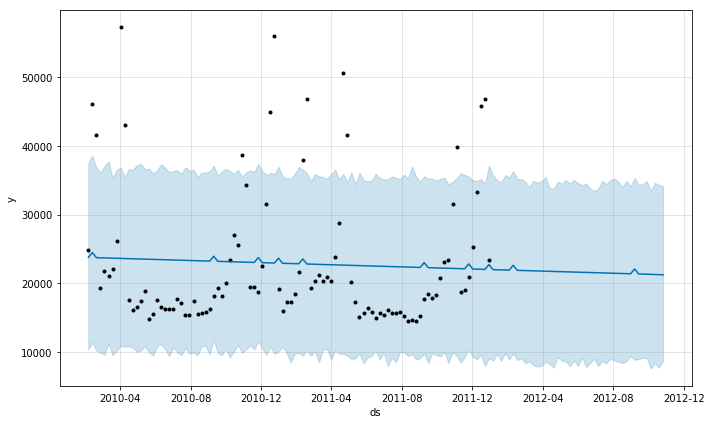

In [49]:
# Plot the forecst
model.plot(forecast);

In [50]:
#Original data (black dots), the model (blue line) and the error of the forecast (shaded blue area).

In [51]:
### Question: The model does not seem to fit the actual data (black dots). The shaded blue area which is the
## forecast error is wide

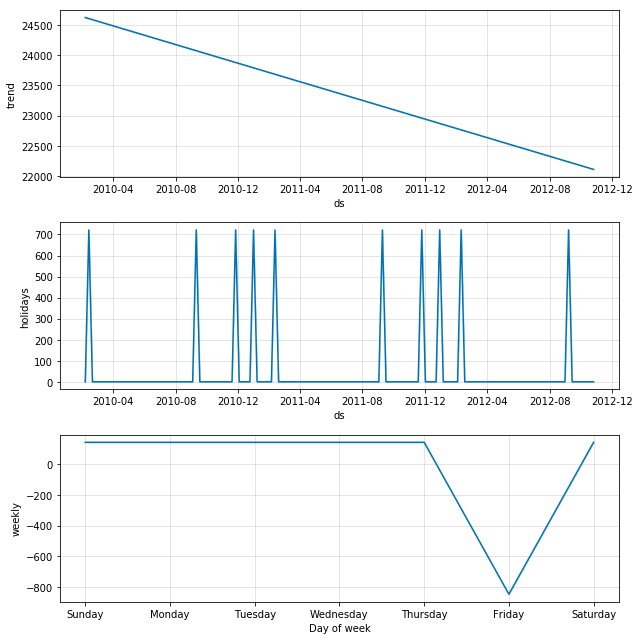

In [52]:
model.plot_components(forecast);

In [53]:
y_hat = forecast['yhat'][100:]

In [54]:
test_df.head()

,ds,y
100,2012-01-06,16567.69
101,2012-01-13,16894.40
102,2012-01-20,18365.10
103,2012-01-27,18378.16
104,2012-02-03,23510.49


In [55]:
y_actual = test_df['y']

In [56]:
metrics_df = forecast.set_index('ds')[['yhat']][100:].join(test_df.set_index('ds').y).reset_index()

In [57]:
metrics_df # where yhat is the predicted and y is the actual value

,ds,yhat,y
0,2012-01-06,22007.801775,16567.69
1,2012-01-13,21990.104718,16894.40
2,2012-01-20,21972.407662,18365.10
3,2012-01-27,21954.710605,18378.16
4,2012-02-03,21937.013549,23510.49
5,2012-02-10,22640.999002,36988.49
6,2012-02-17,21901.619436,54060.10
7,2012-02-24,21883.922379,20124.22
8,2012-03-02,21866.225323,20113.03
9,2012-03-09,21848.528266,21140.07


In [58]:
mean_squared_error(metrics_df.y, metrics_df.yhat)

78192568.434062898

In [59]:
mean_absolute_error(metrics_df.y, metrics_df.yhat)

5629.4271273988879

In [60]:
## Perform Cross validation to measure forecast error

In [61]:
df_cv = cross_validation(model, horizon='120 days')
# Computes forecasts from historical cutoff points. 
# Beginning from initial, makes cutoffs with a spacing of period up to (end - horizon).

In [62]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2011-03-11,23518.963007,10336.487699,37027.732176,21280.40,2011-03-05
1,2011-03-18,23533.124792,10956.868250,36941.134926,20334.23,2011-03-05
2,2011-03-25,23547.286577,10980.981390,36492.536382,20881.10,2011-03-05
3,2011-04-01,23561.448361,9305.964942,36624.027502,20398.09,2011-03-05
4,2011-04-08,23575.610146,10472.554021,37217.562934,23873.79,2011-03-05
5,2011-04-15,23589.771931,10284.280508,37010.644402,28762.37,2011-03-05
6,2011-04-22,23603.933716,11241.487496,38217.787030,50510.31,2011-03-05
7,2011-04-29,23618.095501,10912.051472,36894.042799,41512.39,2011-03-05
8,2011-05-06,23632.257285,10758.777834,38335.798400,20138.19,2011-03-05
9,2011-05-13,23646.419070,10319.945272,36786.413358,17235.15,2011-03-05


In [63]:
mean_squared_error(df_cv.y, df_cv.yhat)

96466131.493734032

In [64]:
mean_absolute_error(df_cv.y, df_cv.yhat)

7776.8746267063343